# Eigenface Implementation for Math 22a Final Project
### Lauren H. Cooke

This notebook will guide you through the python implementation of the eigenface process for facial recognition using **tensors**, or 3D matrices, to represent our color images. This notebook may use some unfamiliar math terminology and will gloss over the written explanation of the eigenface process. For definitions and more detailed explanations of how this process works, feel free to read our accompanying paper. To go through each cell, simply press SHIFT+ENTER. If some red boxes appear as you are running cells, don't worry! These are simply warnings and shouldn't change your experience. Have fun!

## Data and Setup
First, we import the libraries we will need to run the code:

In [15]:
from matplotlib import pyplot as plt
import matplotlib.image as imread
import numpy as np
import os

We then set the data path and image size (in pixels) of the images we will be working with:

In [16]:
dataset_path = 'ImageSet/'
dataset_folder = os.listdir(dataset_path)
height = 4032
width = 3024
colors = 3

Now that we have imported our images, lets take a look at them pre-modification. First, we will examine our training images, or the images that we will use as the 'standard' for what a face looks like. 

This process takes a while because it has to transpose two of the pictures so we can see them! You will know it has completed once the pictures appear and the * disappears from in between the two square brackets next to the box.

Training Images:


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


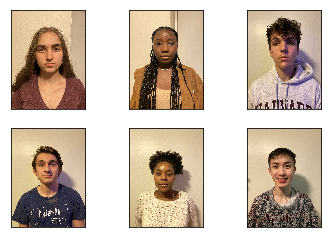

In [17]:
#define function to gather training images
def get_filenames_from_folder(folder_path):
    try:
        # List all files in the given folder
        filenames = os.listdir(folder_path)
        # Filter out directories (if any)
        filenames = [filename for filename in filenames if os.path.isfile(os.path.join(folder_path, filename))]
        # Remove the .DS_Store file if present
        if '.DS_Store' in filenames:
            filenames.remove('.DS_Store')
        return filenames
    except FileNotFoundError:
        print(f"Folder not found: {folder_path}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

#display training images
print('Training Images:')
training_image_names = get_filenames_from_folder(dataset_path)
#defining training tensor: array of image column vectors in \mathbb{R}^{width*height*3}, assigining entry data type to 64bit real numbers
training_tensor  = np.ndarray(shape=(len(training_image_names), height*width*3), dtype=np.float64)
#fill each training image vector with pixel information and add image to graph for us to view
for i in range(len(training_image_names)):
    img = plt.imread(dataset_path + training_image_names[i])
    shape = (4032, 3024, 3)
    if (img.shape == (3024, 4032, 3)):
       img_new = np.zeros(shape)
       for j in range(3024):
           for k in range(4032):
               img_new[k,j] = img[3024-j-1,k-1]
       img = np.reshape(img, shape)
       img = img_new
       img = img.astype(np.uint8)
    training_tensor[i,:] = np.array(img, dtype=np.float64).flatten()
    #print(img.shape)
    plt.subplot(int(np.ceil(len(training_image_names)/3)),3,1+i)
    plt.imshow(img, cmap='RdGy')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Image Processing

Given that these images are our model faces, we then want to represent what they have in common to get a better understanding of what a face is. To do this, we create our average face by averaging the pixel information from each image to a single picture (this process also takes a long time because our pictures are so big. You will know it has completed when the image appears underneath it): 

average face


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


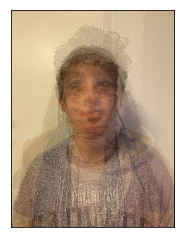

In [18]:
#calculate the average face over our training dataset
#define average image vector as the first image vector (flattened) with the weight of 1 image in our set
#note: .flatten() collapses array into 1D in row order
img = plt.imread(dataset_path + training_image_names[0])
avg_face = img
avg_face = avg_face.flatten()
avg_face = np.divide(avg_face,len(training_image_names))

#weighted sum all color information from all training image vectors
for i in training_image_names:
    if i == training_image_names[0]:
        pass
    else:

        imgs = plt.imread(dataset_path + i)
        imgs = plt.imread(dataset_path + i)
        shape = (4032, 3024, 3)
        if (imgs.shape == (3024, 4032, 3)):
            imgs_new = np.zeros(shape)
            for j in range(3024):
                for k in range(4032):
                    imgs_new[k, j] = imgs[3024 - j - 1, k - 1]
            imgs = np.reshape(imgs, shape)
            imgs = imgs_new
            imgs = imgs.astype(np.uint8)

        imgs = imgs.flatten()
        avg_face = np.add(np.divide(imgs, len(training_image_names)), avg_face)

#convert datatype of elements from float to pixel scalar
avg_face = avg_face.astype(np.uint8)

#display average face
print('average face')
plt.imshow(avg_face.reshape(height,width,colors), cmap='RdGy')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

This is the first spot where I want to talk about potential error reduction. As you can see from this average face, none of the model face images were taken in an environment where we could line people's faces up so that their prominent features would be in the same place per picture. Without this lineup, our program will assign importance to the placement of certain people's features in the frame of the photo rather than only looking at the differences between these features in appearance. So, to improve the accuracy of the algorithm, it would be helpful to create more ideal data!

Next, we need to figure out what makes each of our faces in our model set unique so we can use their special features to best represent an unknown face. To do this, we will normalize our faces by subtracting the average face from each individual face, leaving behind their unique features. (For more information about what the crazy coloration corresponds to, feel free to check out our paper!)

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


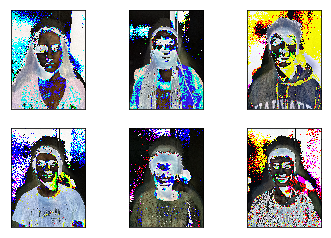

In [19]:
#create normalized training faces using the average face from before
normalized_training_tensor = np.ndarray(shape=(len(training_image_names),height*width*colors))
#convert datatype of elements from float to pixel scalar
#normalized_training_tensor = normalized_training_tensor.astype(np.uint8)
#per image, subtract the mean_face data from the training tensor data
for i in range(len(training_image_names)):
    normalized_training_tensor[i] = np.subtract(training_tensor[i].flatten(), avg_face.flatten())
#convert datatype of elements from float to pixel scalar
normalized_training_tensor = normalized_training_tensor.astype(np.uint8)


#display normalized training faces
for i in range(len(training_image_names)):
    img = normalized_training_tensor[i].reshape(height, width, colors)
    plt.subplot(2, 3, 1 + i)
    plt.imshow(img, cmap='RdGy')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')
plt.show()

Next, we calculate our covariance matrix to represent the variation between our images:

In [20]:
#calculate the covariance matrix
covariance_matrix = np.cov(normalized_training_tensor)
covariance_matrix = np.divide(covariance_matrix,len(training_image_names))
covariance_matrix = covariance_matrix.astype(np.uint8)

#display the cov_matrix
print(covariance_matrix)

[[ 52  79 214 162 253 207]
 [ 79 217  98  97 219  44]
 [214  98  14 187 106  76]
 [162  97 187 148  58  84]
 [253 219 106  58  61 187]
 [207  44  76  84 187  17]]


From our covariance matrix, we find our eigenvalues and eigenvectors and pair them up:

In [21]:
#get the eigenvalues and eigenvectors from the covariance matrix
eigenvalues, eigenvectors, = np.linalg.eig(covariance_matrix)
print("Eigenvectors:")
print(eigenvectors)

print("\n Eigenvalues:")
print(eigenvalues)

#make the eigenpairs and sort them in descending order
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

Eigenvectors:
[[-0.48595401 -0.24313814  0.26922613  0.72243996  0.24037465  0.22923868]
 [-0.39606994  0.77661035 -0.36468678  0.22402578 -0.06001693 -0.23069229]
 [-0.37105585 -0.25585778 -0.22078574 -0.3544056   0.68193614 -0.3968221 ]
 [-0.37677949 -0.427581   -0.62372134 -0.08257108 -0.47279729  0.23627976]
 [-0.45920721  0.25778726  0.37330792 -0.53587446  0.00587698  0.54416881]
 [-0.34126356 -0.15171426  0.4662482  -0.09116033 -0.50000927 -0.62033467]]

 Eigenvalues:
[ 789.83677015  170.67387222  103.47724896 -260.78405844 -103.65371729
 -190.5501156 ]


We then can display what our cumulative proportion of variance, or what the differnces between our images/their significance, looks like in a graph:

Cumulative proportion of variance explained vector: 
[1.55174218 1.88705431 2.09034949 1.88670761 1.51234589 1.        ]


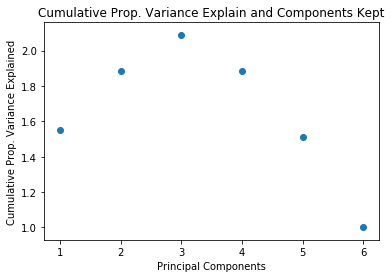

In [22]:
#Find cumulative variance of each principle component
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cumulative Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Prop. Variance Explained')

plt.scatter(num_comp, var_comp_sum)
plt.show()

Using this graph, we determine how many principal components we should use and can form our eigenspace. We can then take a look at our eigenfaces:

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


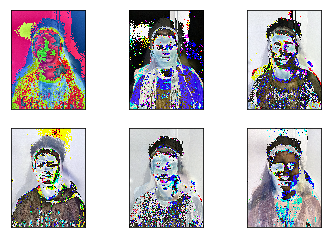

In [23]:
#Choose number of principle components
reduced_data = np.array(eigvectors_sort[:7]).transpose()
#find projected data to form the eigenspace
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()

#display the eigenfaces
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width,colors)
    img = img.astype(np.uint8)
    plt.subplot(2,3,1+i)
    plt.imshow(img, cmap='RdGy')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

From there, we can assign weights to each of our model face images:

In [24]:
#Find weights for each training image
weights = np.array([np.dot(proj_data,i) for i in normalized_training_tensor])
print(weights)

[[-1.91582366e+12  2.29341528e+10 -3.06687752e+10 -7.69563009e+09
  -1.87549970e+11 -2.97296843e+11]
 [-1.08270474e+12 -5.97269668e+10  4.53171556e+10  3.33014493e+10
  -8.64515143e+10 -1.97391592e+11]
 [-1.76111697e+12  2.51816848e+10 -1.10808868e+10 -7.37349154e+10
  -1.22102700e+11 -1.28129889e+11]
 [-1.72539370e+12  2.52476619e+10  3.58292787e+10  6.91320848e+10
  -1.48585627e+11 -2.19839038e+11]
 [-8.17970439e+11 -8.19742466e+09  4.27142896e+07  8.75948033e+09
  -8.89096228e+10 -8.15197250e+10]
 [-1.73684175e+12  2.92049312e+10 -2.99302349e+10  5.19753047e+10
  -1.06378653e+11 -1.86890502e+11]]


## Testing
Now that we have done all of this work on our model faces, what can we do with an unknown image? Can we determine if it matches one of our model faces? To find out, let's first pick an unidentified image to work with:

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


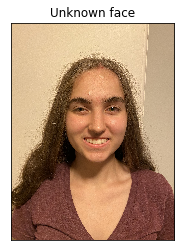

In [25]:
#read unknown face
unknown_face = plt.imread('ImageSet/Test/IMG_8582.jpg')
unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()

#display unknown face
plt.imshow(unknown_face, cmap='RdGy')
plt.title('Unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

Now in our minds, its pretty clear that this picture is a face and that it is the same face as the first picture in our model face space. (Scroll back up to look at the series of pictures at the top of the document!) But, to a computer, these pictures are quite different. Because this person is smiling in this photo, the pixel information around the mouth and the placement of her features are completely different. So, what can the computer do to figure out if this picture is of a face it knows?

First, we are going to want to highlight what differentiates this picture from a generic face, so we will normalize it in the same way that we normalized our model images from before:

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


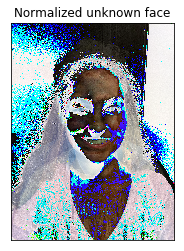

In [26]:
#normalize unknown face
normalized_uface_vector = np.subtract(unknown_face_vector.flatten(),avg_face.flatten())
normalized_uface_vector = normalized_uface_vector.astype(np.uint8)
plt.imshow(normalized_uface_vector.reshape(height, width,colors), cmap='RdGy')
plt.title('Normalized unknown face')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

With this modified image, we can find the weight assigned to it by projecting the normalized vector onto the eigenspace that we built with our model images (a simple dot product!):

In [27]:
#find the weight of the unknown face by projecting the normalized vector onto the eigenspace
weight_unknown = np.dot(proj_data, unknown_face_vector)
print(weight_unknown)

[-1.96276534e+12  1.47425295e+10 -6.33914745e+09 -5.29174375e+10
 -1.35539803e+11 -1.16016885e+11]


Then, to match our image to a known face, we will figure out which known weights are the most similar to our new image weights by finding the minimum difference:

In [28]:
dif = weights - weight_unknown
norms = np.linalg.norm(dif,axis=1)
index = 0
for i in range(len(norms)):
    if norms[i] == min(norms):
        print(i)
        index = i

0


Thus, image 0 (python is 0 based, so this is the first image of our set) looks the most similar to our unknown image. So, we have found our matching face and can show our user:

This face best matches image


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


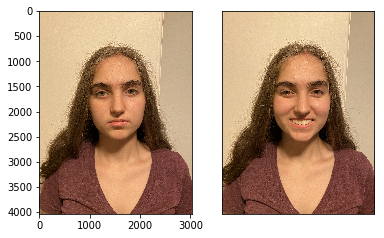

In [29]:
print('This face best matches image')
imgknown = plt.imread(dataset_path + training_image_names[index])
#ingnew =
#plt.imshow(normalized_uface_vector.reshape(height, width,colors), cmap='RdGy')
plt.subplot(1,2,1)
plt.imshow(imgknown, cmap='RdGy')
plt.subplot(1,2,2)
plt.imshow(unknown_face, cmap='RdGy')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

And there you have it! A computer successfully recognized an unknown face and matched it to a face it had seen before. Using a process like this, there are so many things that computers can learn to classify. As I said at the beginning of this demo, for more information about the implications of, mathematical reasoning behind, and applications of eigenfaces, please consider reading our paper. Thank you.